# score

> Quantify staining of IHC images

In [ ]:
#| default_exp score

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import numpy as np
from matplotlib import pyplot

## Pixel-wise H score

In [ ]:
#| export
def compute_pxlhscore(
        hed_img, 
        h_threshold=0.05, d_thresholds=[0.12, 0.24, 0.6],
        verbose=False):
    """

    Computes the pixel H-score for a given HED (Hematoxylin and Eosin-DAB) stained image.
    
    The H-score is calculated based on the intensity of the DAB stain, which is 
    indicative of the presence and quantity of a specific biomarker in IHC images. 
    The function allows for automatic thresholding based on the distribution of staining intensities.
    Inspired by the implementation in Ram et al. 2021.
    
    Parameters:

    - hed_img (numpy.ndarray): The HED-stained image as a NumPy array of shape 
        (height, width, channels).

    - h_threshold (str or float): Threshold for Hematoxylin intensity. 
        If 'auto', the threshold is set to the mean intensity.

    - d_thresholds (str or list of floats): Thresholds for DAB intensity, 
        defining negative, low, medium, and high intensity ranges. 
        If 'auto', thresholds are set to the 90th, 94.95th, and 99.9th percentiles.

    - verbose (bool): If True, displays histograms of the distributions of 
        Hematoxylin and DAB stain values, and images showing pixels classified 
        as high, medium, low, and negative DAB stained.
    
    Returns:

    - pxlHscore (float): The pixel H-score, a weighted sum of pixels classified 
        as having high, medium, or low DAB intensity, 
        normalized by the total number of pixels considered.
        
    """
    
    # Flatten the H and D channels for thresholding and histogram plotting
    h_array = hed_img[:, :, 0].flatten()
    d_array = hed_img[:, :, 2].flatten()
    
    # Automatic thresholding for Hematoxylin if requested
    if h_threshold == "auto":
        h_threshold = np.mean(h_array)
    
    # Automatic thresholding for DAB if requested
    if d_thresholds == "auto":
        d_thresholds = np.quantile(d_array, [0.9, 0.9495, 0.999])
    
    # Plotting histograms if verbose mode is on
    if verbose:
        pyplot.figure()
        pyplot.hist(d_array, bins=50, density=True, cumulative=False, color="blue", edgecolor="black")
        pyplot.yscale("log")
        pyplot.title("Distribution of DAB stain Values")
        pyplot.xlabel("Value")
        pyplot.ylabel("Frequency (log scale)")
        pyplot.show()
        
        pyplot.figure()
        pyplot.hist(h_array, bins=50, density=True, cumulative=False, color="blue", edgecolor="black")
        pyplot.yscale("log")
        pyplot.title("Distribution of Hematoxylin Values")
        pyplot.xlabel("Value")
        pyplot.ylabel("Frequency (log scale)")
        pyplot.show()
    
    # Classifying pixels based on DAB intensity thresholds
    h_pixels = hed_img[:, :, 0] > h_threshold
    dn_pixels = hed_img[:, :, 2] < d_thresholds[0]
    dl_pixels = (hed_img[:, :, 2] >= d_thresholds[0]) & (hed_img[:, :, 2] < d_thresholds[1])
    dm_pixels = (hed_img[:, :, 2] >= d_thresholds[1]) & (hed_img[:, :, 2] < d_thresholds[2])
    dh_pixels = hed_img[:, :, 2] >= d_thresholds[2]
    n_pixels = h_pixels & dn_pixels
    
    # Displaying classified pixels if verbose mode is on
    if verbose:
        print(f"Mean intensity for H pixels: {h_pixels.mean()}")
        print(f"Mean intensity for DN pixels: {dn_pixels.mean()}")
        print(f"Mean intensity for DL pixels: {dl_pixels.mean()}")
        print(f"Mean intensity for DM pixels: {dm_pixels.mean()}")
        print(f"Mean intensity for DH pixels: {dh_pixels.mean()}")
        print(f"Mean intensity for N pixels: {n_pixels.mean()}")
        
        fig, axs = matplotlib.pyplot.subplots(2, 2, figsize=(6, 6))
        axs[0, 0].imshow(dh_pixels)
        axs[0, 0].set_title("High DAB")
        axs[0, 1].imshow(dm_pixels)
        axs[0, 1].set_title("Med DAB")
        axs[1, 0].imshow(dl_pixels)
        axs[1, 0].set_title("Low DAB")
        axs[1, 1].imshow(n_pixels)
        axs[1, 1].set_title("Negative")
        for ax_row in axs:
            for ax in ax_row:
                ax.axis("off")
        matplotlib.pyplot.show()
    
    # Calculating the pixel H-score
    dh_pixels_sum = dh_pixels.sum()
    dm_pixels_sum = dm_pixels.sum()
    dl_pixels_sum = dl_pixels.sum()
    pxlHscore = 100 * (3 * dh_pixels_sum + 2 * dm_pixels_sum + dl_pixels_sum) / (dh_pixels_sum + dm_pixels_sum + dl_pixels_sum + n_pixels.sum())
    
    if verbose:
        print(f"Pixel H-score: {pxlHscore}")
    
    return pxlHscore

The pixelwise H-score is computed as follows:

$$\
pxlH = 100 \times \frac{3 \times N_{DH} + 2 \times N_{DM} + N_{DL}}{N_{DH} + N_{DM} + N_{DL} + N_{N}}
$$

where:
- $\N_{DH}$ is the number of pixels with high DAB intensity,
- $\N_{DM}$ is the number of pixels with medium DAB intensity,
- $\N_{DL}$ is the number of pixels with low DAB intensity,
- $\N_{N}$ is the number of pixels with negative DAB intensity.

Example

In [ ]:
import skimage as ski

<matplotlib.image.AxesImage>

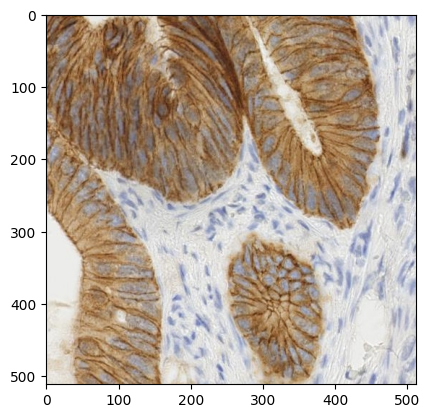

In [ ]:
ihc_rgb = ski.data.immunohistochemistry()
pyplot.imshow(ihc_rgb)

In [ ]:
ihc_hed = ski.color.rgb2hed(ihc_rgb)

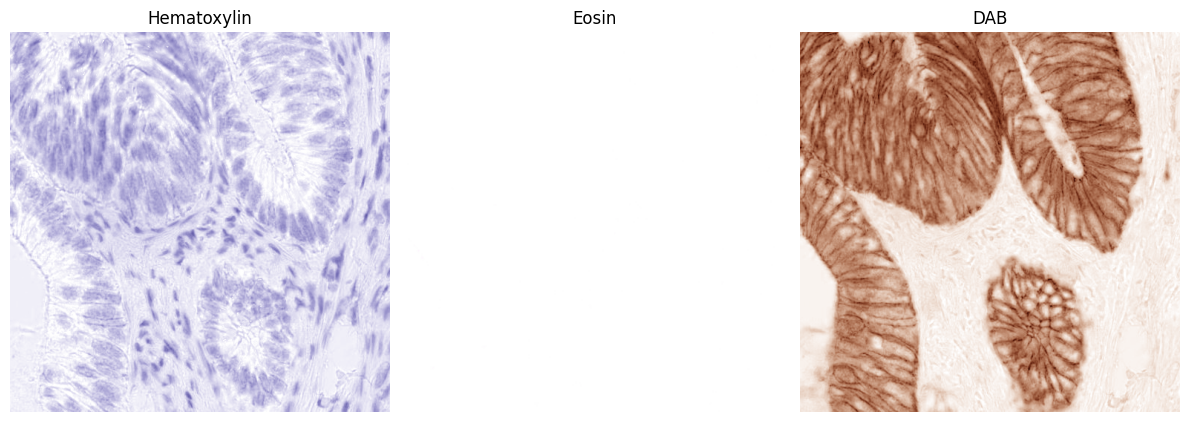

In [ ]:
stain_names = ["Hematoxylin", "Eosin", "DAB"]
fig, axes = pyplot.subplots(1, 3, figsize=(12, 6)) 

null = np.zeros_like(ihc_hed[:, :, 0])

for i, name in enumerate(stain_names):
    # Create an RGB image for the current stain
    channels = [null, null, null]
    channels[i] = ihc_hed[:, :, i]
    rgb_img = ski.color.hed2rgb(np.stack(channels, axis=-1))
    
    # Display
    axes[i].imshow(rgb_img)
    axes[i].set_title(name)
    axes[i].axis("off")

pyplot.tight_layout()
pyplot.show()

In [ ]:
result = compute_pxlhscore(ihc_hed)
print(result)

79.24793673539793


In [ ]:
assert round(compute_pxlhscore(ihc_hed), ndigits=3) == 79.248

In [ ]:
assert round(compute_pxlhscore(ihc_hed,h_threshold="auto", d_thresholds="auto"), ndigits=3) == 32.689

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()